In [1]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

In [2]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [122]:
from solvers import agglomeration_grid_2d, agglomeration_pa_2d
from compress import compress
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic, binned_statistic_2d, norm
import pandas as pd
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

In [200]:
L_edges_0 = np.arange(0, 20, 0.5)
L_edges_1 = np.arange(0, 20, 0.5)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0]) 

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(z, loc=0, scale=3)

dt = 0.1
t_total = 10.
kernel_coef = np.array([1., 1.])
aggl_powers = np.array([2., 1.])

In [201]:
n = n_init.copy()

cnts = [(n * L_edge_diff_area).sum()]
vols = [(n * Lc0**2 * Lc1 * L_edge_diff_area).sum()]
ts = [0]
_d = [0]
pbar = tqdm(total=t_total)
t = 0
while t < t_total:
    B, D = agglomeration_grid_2d(n, L_edges, L_centers, kernel_coef, aggl_powers, min_count=1e-18)
    n += (B - D) * dt
    t += dt
    _d.append((B-D).sum() * L_edge_diff_area)
    assert np.all(n >= 0)
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    cnt = (n * L_edge_diff_area).sum()
    vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
    cnts.append(cnt)
    vols.append(vol)
    ts.append(t)
    # break
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

In [204]:
N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0]
N_init = N.copy()
pbar = tqdm(total=t_total)
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [0]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
pa_d = [0]
ginterval = 0.5
N = compress(N, ginterval, aggl_powers, 1, )

while t < t_total:
    v_original = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    Bs, D = agglomeration_pa_2d(N, (0.3, 0.3), kernel_coef, aggl_powers, min_count=1e-9)
    B = np.vstack(Bs)
    pa_d.append(B[:, -1].sum() - D.sum())
    assert np.isclose(D.sum(), B[:, -1].sum()*2) # count rate equal
    assert np.isclose((N[:, 0]**2 * N[:, 1] * D).sum(), (B[:, 0]**2 * B[:, 1] * B[:, -1]).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt
    
    N = np.vstack((N, B))
    v_before_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_original)
    N = compress(N, ginterval, aggl_powers, 1, )
    v_after_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_after_compression)
    t += dt
    pbar.update(dt)
    pa_cnts.append(N[:, -1].sum())
    pa_ts.append(t)
    pa_vols.append(v_after_compression)
pbar.close()

  0%|          | 0/10.0 [00:00<?, ?it/s]

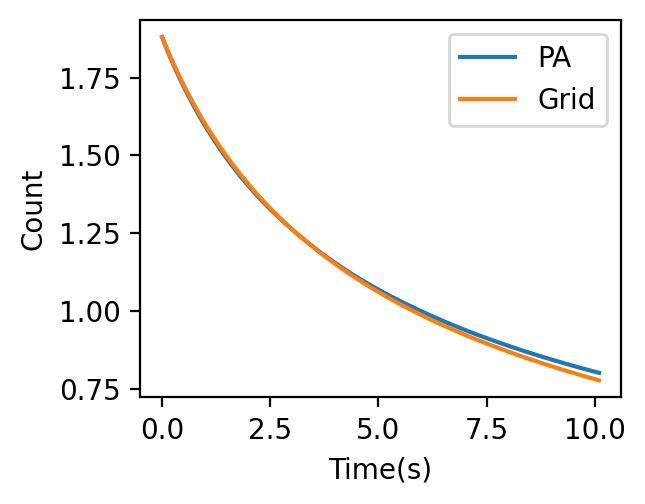

In [205]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(pa_ts, pa_cnts, label="PA")
ax.plot(ts, cnts, label="Grid")
ax.set_xlabel("Time(s)")
ax.set_ylabel("Count")
ax.legend()
# save_fig(fig, "agglomeration_2d_count_profile")

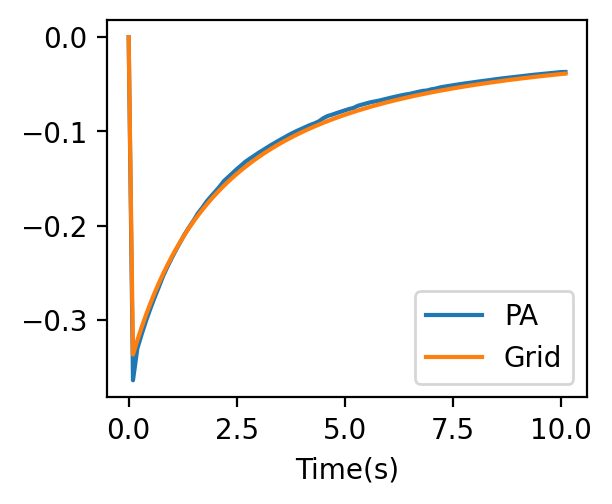

In [206]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(pa_ts, pa_d, label="PA")
ax.plot(ts, _d, label="Grid")
ax.set_xlabel("Time(s)")
ax.legend()

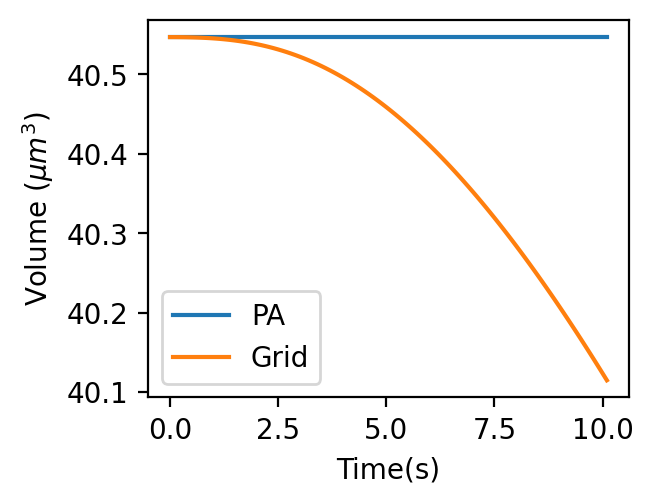

In [207]:
fig, ax = plt.subplots(dpi=200, figsize=(3.1, 2.5))
ax.plot(pa_ts, pa_vols, label="PA")
ax.plot(ts, vols, label="Grid")
ax.set_xlabel("Time(s)")
ax.set_ylabel("Volume $(\mu m^3)$")
ax.legend()
save_fig(fig, "agglomeration_2d_volume_profile")

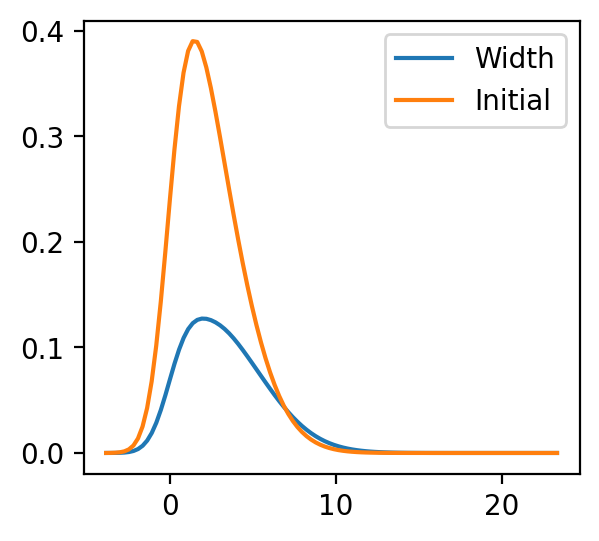

In [208]:
from KDEpy import FFTKDE

fig, ax = plt.subplots(dpi=200, figsize=(3.2, 3))
kde = FFTKDE()
kde.fit(N[:, 0], N[:, -1])
x, y = kde.evaluate(100)
ax.plot(x, y * N[:, -1].sum(), label="Width")

kde.fit(N_init[:, 0], N_init[:, -1])
x, y = kde.evaluate(100)
ax.plot(x, y * N_init[:, -1].sum(), label="Initial")
ax.legend()

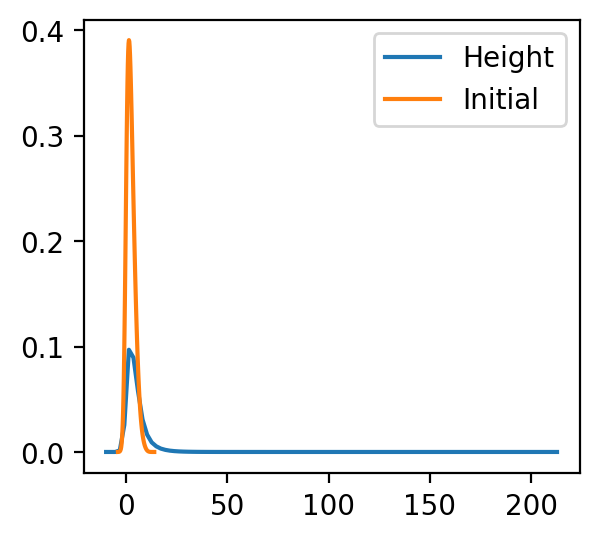

In [52]:
from KDEpy import FFTKDE

fig, ax = plt.subplots(dpi=200, figsize=(3.2, 3))
kde = FFTKDE()
kde.fit(N[:, 1], N[:, -1])
x, y = kde.evaluate(100)
ax.plot(x, y * N[:, -1].sum(), label="Height")

kde.fit(N_init[:, 1], N_init[:, -1])
x, y = kde.evaluate(100)
ax.plot(x, y * N_init[:, -1].sum(), label="Initial")
ax.legend()

In [79]:
# Test single point agglomeration
dt = 0.2
N = np.array([[1.0, 1.0, 1.]])
_D = []
for i in np.arange(0., 1., dt):
    Bs, D = agglomeration_pa_2d(N, (30, 30), kernel_coef, aggl_powers, min_count=1e-9)
    B = np.vstack(Bs)
    N[:, -1] -= dt * D
    B[:, -1] *= dt
    N = np.vstack([N, B])
    _D.append(B[:, -1].sum() - D.sum())
